# Parsing the ⭐'s with txtai

[txtai](https://github.com/neuml/txtai) is an all-in-one embeddings database for semantic search, LLM orchestration and language model workflows.

In honor of txtai's recent milestone of reaching 10K ⭐'s on GitHub, this notebook will build an astronomical knowledge graph of known stars, planets, galaxies and other astronomical entities. It will show how a compendium of information can be built from a public knowledge source such as Wikipedia.

While agents and retrieval augmented generation (RAG) can do great things, they can do even greater things if provided with an assist from the humans in the form of compiled knowledge. It's not only better accuracy, it's also faster as we don't need to wait for an agent to figure out what we already know.

Let's dive in.

# Install dependencies

Install `txtai` and all dependencies.

In [ ]:
%%capture
!pip install git+https://github.com/neuml/txtai#egg=txtai[agent,graph,pipeline-text] datasets autoawq autoawq-kernels

# Build the Knowledge Graph

The first step is building our knowledge graph or compendium of information. We'll use [txtai-wikipedia](https://hf.co/neuml/txtai-wikipedia) and another source derived from wikipedia with known [stars by constellation](https://huggingface.co/datasets/NeuML/constellations).

We'll select articles about planets, constellations, galaxies and stars. We'll then extract entities using a [GLiNER pipeline](https://github.com/urchade/GLiNER). Lastly, we'll join those entries together with the constellation data.

To get an idea of what this data will look like, below is the schema for the `constellation` dataset.

The following is a description of each of the fields in this dataset. As we can see, there is a lot of identifiers but it also has data such as it's location, brightness and distance from earth.

| Field               | Description                                                       |
| ------------------- | ----------------------------------------------------------------- | 
| Constellation       | Name of the constellation the star is a part of                   |
| Name                | Proper name                                                       |
| Bayer               | Bayer designation                                                 |
| Flamsteed           | Flamsteed designation                                             |
| Variable Star       | Variable star designation                                         |
| Henry Draper Number | Henry Draper Catalogue designation number                         |
| Hipparcos Number    | Hipparcos Catalogue designation number                            |
| Right Ascension     | Right ascension for the Epoch/Equinox J2000.0                     |
| Declination         | Declination for the Epoch/Equinox J2000.0                         |
| Visual Magnitude    | Visual Magnitude (m or mv), also known as apparent magnitude      |
| Absolute Magnitude  | Absolute Magnitude (Mv)                                           | 
| Distance            | Distance in light-years from Earth                                |
| Spectral class      | Spectral class of the star in the stellar classification system   |
| Notes               | Common name(s) or alternate name(s); comments; notable properties |


In [ ]:
from txtai import Embeddings

embeddings = Embeddings()
embeddings.load(provider="huggingface-hub", container="neuml/txtai-wikipedia")

In [ ]:
from txtai.pipeline import Entity

entity = Entity("gliner-community/gliner_medium-v2.5")

In [21]:
from datasets import load_dataset

def parsefloat(value):
    try:
        return float(value.replace("−", "-")) if value else value
    except ValueError:
        return value

def parse(star):
    text = star["Name"] if star["Name"] else f'HD-{star["Henry Draper Number"]}'

    output = {"id": star["Name"], "type": "star", "text": text}
    for field, value in star.items():
        field = field.lower().replace(" ", "_")
        output[field] = parsefloat(value)

    return output

# Star by constellation dataset
stars = load_dataset("neuml/constellations", split="train")

The sections above loaded `txtai-wikipedia`, the `GLiNER` pipeline, and the `constellations` dataset. Now it's time to build the knowledge graph!

In [ ]:
from tqdm.auto import tqdm

labels = {
    "name of constellation": "constellation",
    "name of galaxy": "galaxy",
    "name of star in astronomy": "star",
    "name of planet": "planet"
}

def stream():
    # Seed with stars dataset
    rows = {star["Name"]: parse(star) for star in stars}

    # Get wikipedia results
    results = embeddings.search(
        "SELECT id, text, percentile FROM txtai WHERE similar('scientific article defining a constellation, galaxy, star or planet') AND score >= 0.8",
        embeddings.count()
    )

    # Aggregate into entity rows
    for row in tqdm(results):
        entities = entity(row["text"], labels=list(labels.keys()))
        entities = [(entity, labels[tag]) for entity, tag, score in entities if score >= 0.95 and entity != row["id"]]
        if entities or row["id"] in rows:
            # Collect relationships    
            relationships = set()
            for uid, tag in entities:
                if uid not in rows:
                    rows[uid] = {"id": uid, "type": tag, "text": tag}

                relationships.add(uid)

            # Add relationships and yield main record
            row["relationships"] = list(relationships)

            # Merge existing record (if any) and save
            rows[row["id"]] = {**rows[row["id"]], **row} if row["id"] in rows else row

    yield from rows.values()

astronomy = Embeddings(
    path = "intfloat/e5-base",
    instructions={"query": "query: ", "data": "passage: "},
    faiss = {"quantize": True, "sample": 0.05},
    content = True,
    graph = {"approximate": True, "topics": {}, "copyattributes": True}
)
astronomy.index(stream())
astronomy.save("txtai-astronomy")

# Explore the Knowledge Graph

The next section creates a function to plot a knowledge graph. This function is specific to our astronomical data. It color codes galaxies, planets and stars by [spectral class](https://en.wikipedia.org/wiki/Stellar_classification).



In [23]:
import matplotlib.pyplot as plt
import networkx as nx

def plot(graph):
    labels = {x: f"{graph.attribute(x, 'id')}" for x in graph.scan()}
    mapping = {
        "constellation": "#f44336", "galaxy": "#9575cd", "planet": "#9e9e9e", "star": "#ff9800",
        "O": "#92b5ff", "B": "#a2c0ff", "A": "#d5e0ff", "F": "#f9f5ff", "G": "#ffede3",
        "K": "#ffdab5", "M": "#ffb56c"
    }

    colors = []
    for x in graph.scan():
        etype, spectral  = graph.attribute(x, "type"), graph.attribute(x, "spectral_class")
        if etype == "star":
            etype = spectral[0] if spectral else etype
        
        colors.append(mapping.get(etype, "#03a9f4"))

    options = {
        "node_size": 700,
        "node_color": colors,
        "edge_color": "#454545",
        "alpha": 1.0,
    }

    # Draw graph
    fig, ax = plt.subplots(figsize=(20, 9))
    pos = nx.spring_layout(graph.backend, seed=0, k=0.9, iterations=50)
    nx.draw_networkx(graph.backend, pos=pos, with_labels=False, **options)

    # Calculate label positions
    pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

    nx.draw_networkx_labels(
        graph.backend, pos, labels=labels, font_color="#efefef", font_size=10
    )

    # Disable axes and draw margins
    ax.axis("off")
    plt.margins(x=0.15)

    # Set background color
    ax.set_facecolor("#303030")
    fig.set_facecolor("#303030")

    plt.show()

Now we're ready to run a query. `txtai` supports vector queries, SQL queries and Graph queries (using [openCypher](https://github.com/aplbrain/grand-cypher)). As of txtai 8.3, queries are automatically routed to the correct index based on type. 

The path traversal query below takes a starting node and plots the 10 relationships that are closest to earth.

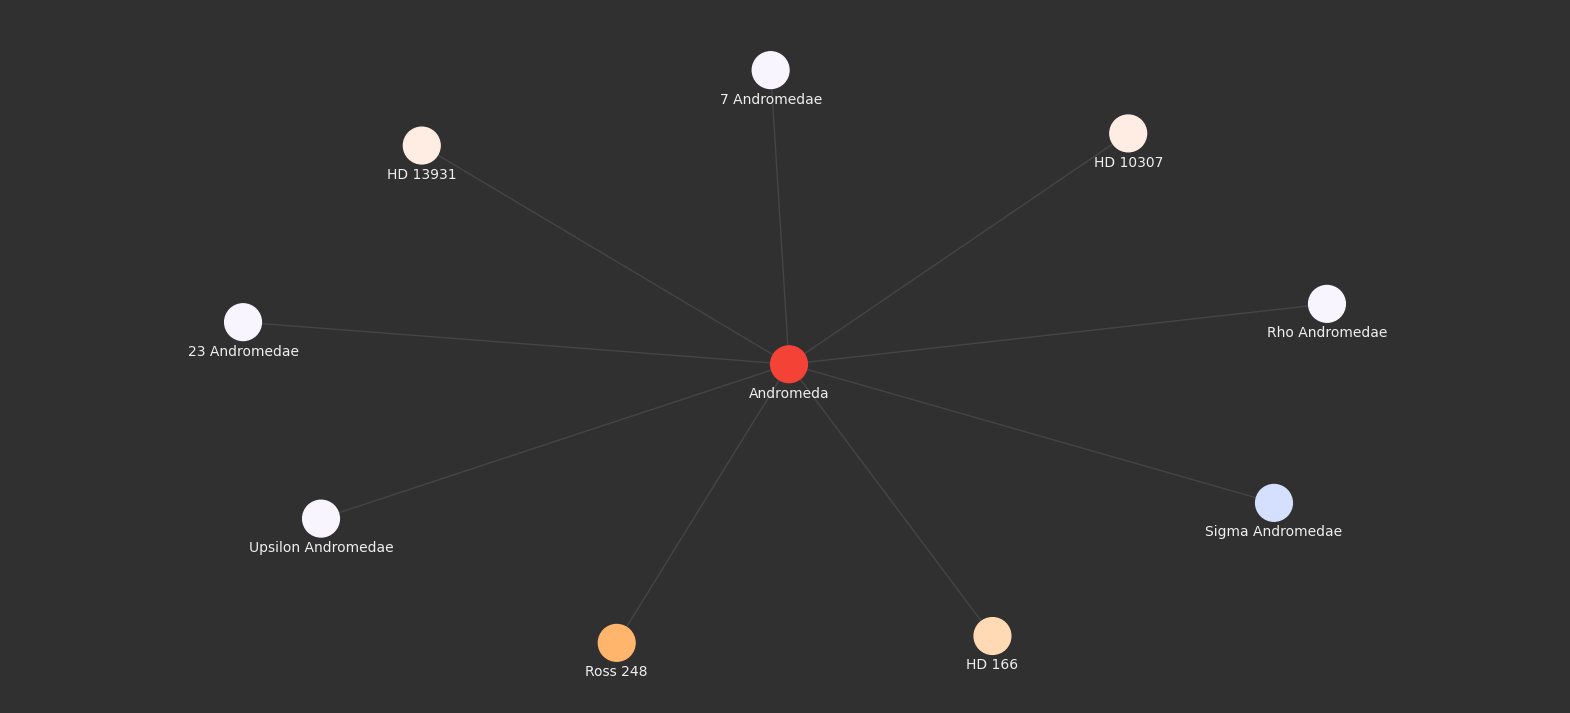

In [24]:
subgraph = astronomy.search("""
MATCH P=({id: "Andromeda"})-[]->(A)
WHERE A.distance > 0
RETURN P 
ORDER BY A.distance
LIMIT 10
""", graph=True)

plot(subgraph)

We can also find stars with planets.

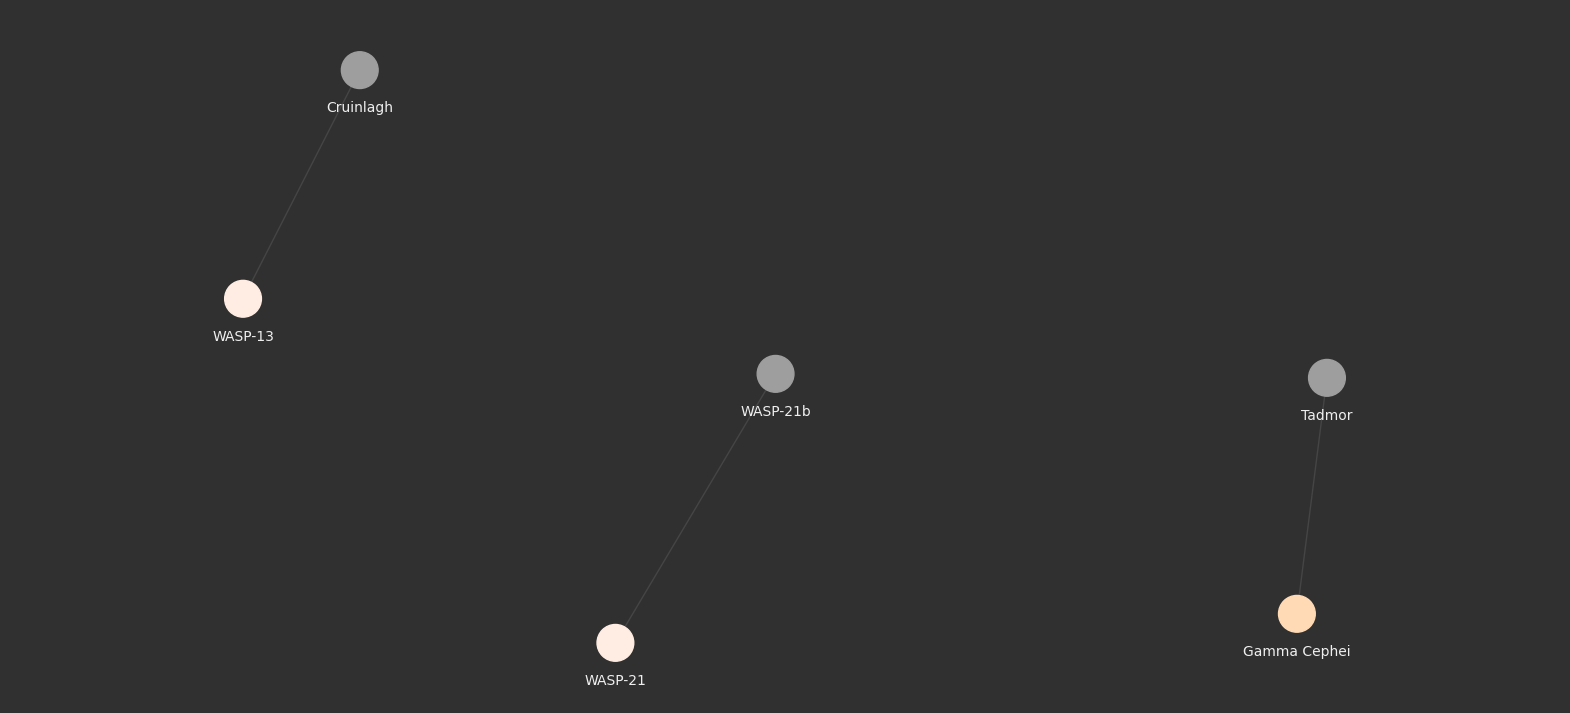

WASP-21b planet
WASP-21 WASP-21 is a G-type star (spectral type G3V) that is reaching the end of its main sequence lifetime  approximately 850 light years from Earth in the constellation of Pegasus. The star is relatively metal-poor, having 40% of heavy elements compared to the Sun. Kinematically, WASP-21 belongs to the thick disk of the Milky Way. It has an exoplanet named WASP-21b.
WASP-13 WASP-13, also named Gloas, is a star in the Lynx constellation. The star is similar, in terms of metallicity and mass, to the Sun, although it is hotter and most likely older. The star was first observed in 1997, according to the SIMBAD database, and was targeted by SuperWASP after the star was observed by one of the SuperWASP telescopes beginning in 2006. Follow-up observations on the star led to the discovery of planet Cruinlagh in 2008; the discovery paper was published in 2009.
Cruinlagh planet
Gamma Cephei Gamma Cephei (γ Cephei, abbreviated Gamma Cep, γ Cep) is a binary star system approximat

In [25]:
subgraph = astronomy.search("""
MATCH P=(A {type: "star"})-[]->(B {type: "planet"})
WHERE B.id <> "Jupiter" AND B.id <> "Saturn"
RETURN P
""", graph=True)

plot(subgraph)

for x in subgraph.scan():
    print(subgraph.attribute(x, "id"), subgraph.attribute(x, "text"))

Standard SQL queries are also supported. Let's show the stars that are brightest from Earth.

In [26]:
astronomy.search("""
SELECT id, text, visual_magnitude FROM txtai
WHERE visual_magnitude IS NOT NULL
ORDER BY visual_magnitude
LIMIT 5
""")

[{'id': 'Sirius',
  'text': "Sirius is the brightest star in the night sky. Its name is derived from the Greek word  (Latin script: ), meaning  'glowing' or 'scorching'. The star is designated \xa0Canis Majoris, Latinized to Alpha Canis Majoris, and abbreviated \xa0CMa or Alpha\xa0CMa. With a visual apparent magnitude of −1.46, Sirius is almost twice as bright as Canopus, the next brightest star. Sirius is a binary star consisting of a main-sequence star of spectral type A0 or A1, termed Sirius\xa0A, and a faint white dwarf companion of spectral type\xa0DA2, termed Sirius\xa0B. The distance between the two varies between 8.2 and 31.5\xa0astronomical units as they orbit every 50\xa0years.",
  'visual_magnitude': -1.46},
 {'id': 'Canopus',
  'text': 'Canopus is the brightest star in the southern constellation of Carina and the second-brightest star in the night sky. It is also designated α\xa0Carinae, which is romanized (transliterated) to Alpha\xa0Carinae. With a visual apparent magnitu

# Retrieval Augmented Generation (RAG)

Next, we'll run a series of RAG queries using the knowledge graph.

In [ ]:
from txtai import LLM, RAG

# Define prompt template
template = """
Answer the following question using only the context below. Only include information
specifically discussed. Answer the question without explaining how you found the answer.

question: {question}
context: {context}"""

# Load LLM
llm = LLM("hugging-quants/Meta-Llama-3.1-8B-Instruct-AWQ-INT4")

# Create RAG pipeline
rag = RAG(
    astronomy,
    llm, 
    system="You are a friendly assistant. You answer questions from users.",
    template=template,
    context=10
)

In [59]:
print(rag("Tell me about the stars in the Andromeda constellation and how far they are from Earth", maxlength=4096)["answer"])

The stars in the Andromeda constellation mentioned in the context include:

1. Omicron Andromedae (ο And), a blue-white B-type giant approximately 692 light years from Earth.
2. RT Andromedae, a variable star approximately 322 light years from Earth.
3. 8 Andromedae, a probable triple star system approximately 570 light years from Earth.
4. 64 Andromedae, a deep-yellow coloured G-type giant approximately 419 light years from Earth.
5. 3 Andromedae, a single star approximately 181 light years from Earth.
6. Epsilon Andromedae, a star approximately 155 light years from the Sun.
7. HD 166 or V439 Andromedae, a variable star approximately 45 light years away from Earth.
8. 7 Andromedae, a single, yellow-white hued star approximately 79.6 light years from Earth.
9. 18 Andromedae, a single star approximately 413 light years from Earth.
10. 12 Andromedae, a single star approximately 137 light years from Earth.

These stars vary in their distance from Earth, ranging from 45 to 692 light years.

Now let's try a Graph RAG query. Instead of vector search, we'll run a graph traversal query to generate the RAG context.

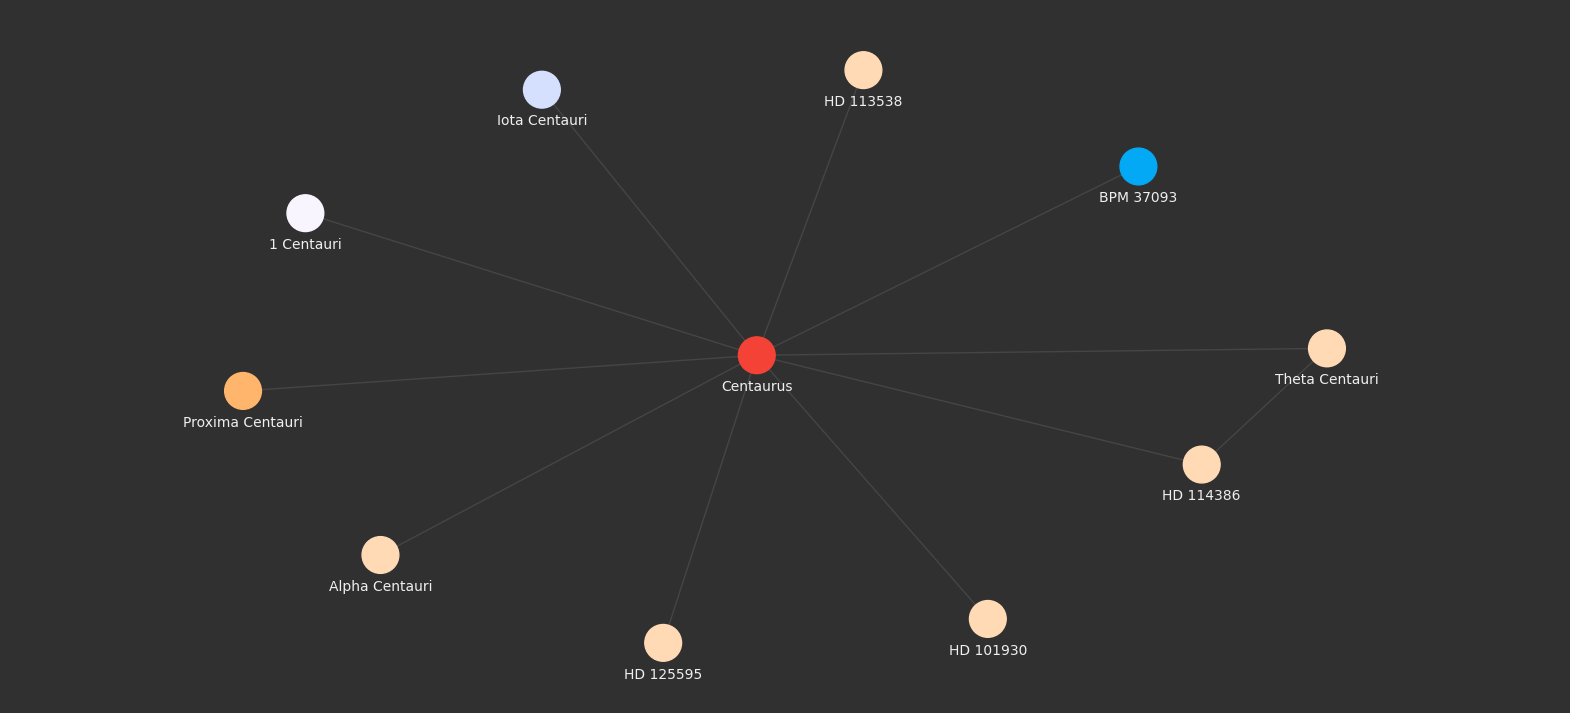

Here's a summary of the stars discussed along with a short description about them, sorted by distance to Earth:

1. **Proxima Centauri**: The closest star to Earth after the Sun, located 4.25 light-years away. It's a small, low-mass star too faint to be seen with the naked eye.

2. **Alpha Centauri (Rigil Kentaurus, Toliman, and Proxima Centauri)**: A triple star system located 4.25 light-years away. It consists of three stars: Rigil Kentaurus, Toliman, and Proxima Centauri.

3. **Iota Centauri**: A star located approximately 51.5 light-years away. It has an apparent visual magnitude of +2.73, making it easily visible to the naked eye.

4. **HD 113538 (Gliese 496.1)**: A star with two planetary companions located 53 light-years away. It is much too faint to be viewed with the naked eye.

5. **HD 101930 (Gliese 3683)**: An orange-hued star with an orbiting exoplanet located 98 light-years away. It has a relatively large proper motion and is receding with a radial velocity of.

6. **HD 1

In [60]:
subgraph = astronomy.search("""
MATCH P=({id: "Centaurus"})-[]->(B)
WHERE B.distance > 0
RETURN P
ORDER BY B.distance
LIMIT 10
""", graph=True)

plot(subgraph)

command = """
Write a summary of the stars discussed along with a short description about them.
Sort by distance to Earth.
"""

context = [subgraph.attribute(x, "text") for x in subgraph.scan()]
print(rag(command, context, maxlength=4096)["answer"])

# Agents

Our last example is an Agent that searches the astronomy knowledge graph.

In [ ]:
from txtai import Agent

def search(query):
    """
    Searches a database of astronomy data.

    Make sure to call this tool only with a string input, never use JSON.    

    Args:
        query: concepts to search for using similarity search
 
    Returns:
        list of search results with for each match
    """

    return embeddings.search(
        "SELECT id, text, distance FROM txtai WHERE similar(:query)",
        10, parameters={"query": query}
    )

agent = Agent(
    tools=[search],
    llm=llm,
    max_iterations=10,
)

In [124]:
from IPython.display import display, Markdown

def md(output):
    display(Markdown(output))

researcher = """
{command}

Do the following.
 - Search for results related to the topic.
 - Analyze the results
 - Continue querying until conclusive answers are found
 - Write a Markdown report
"""

md(agent(researcher.format(command="""
Write a detailed list with explanations of 10 candidate stars that could potentially be habitable to life.
"""), maxlength=16000))


======== New task ========


Write a detailed list with explanations of 10 candidate stars that could potentially be habitable to life.


Do the following.
 - Search for results related to the topic.
 - Analyze the results
 - Continue querying until conclusive answers are found
 - Write a Markdown report

=== Agent thoughts:
Thought: I will need to find the list of candidate stars that could potentially be habitable to life. To do this, I will use the `search` tool to look for related results.
>>> Calling tool: 'search' with arguments: candidate stars for habitable planets
=== Agent thoughts:
Thought: The results from the `search` tool provide a list of candidate stars for habitable planets. However, they are not organized in a clear and concise manner. To create a detailed list with explanations, I will need to analyze the results and identify the key points.
>>> Calling tool: 'final_answer' with arguments: {'answer': "Here is a list of 10 candidate stars that could potentially be hab

Here is a list of 10 candidate stars that could potentially be habitable to life:

1. Luyten's Star (red dwarf star) - has a confirmed exoplanet, Luyten b, which is a super-Earth and receives only 6% more starlight than Earth.

2. Gliese 273 (red dwarf star) - has a confirmed exoplanet, Luyten b, which is a super-Earth and receives only 6% more starlight than Earth.

3. Ross 128 (red dwarf star) - has a confirmed exoplanet, Ross 128 b, which is a super-Earth and receives only 6% more starlight than Earth.

4. Proxima Centauri (red dwarf star) - has a confirmed exoplanet, Proxima Centauri b, which is a super-Earth and receives only 6% more starlight than Earth.

5. Kepler-560 (binary star system) - has a confirmed exoplanet, Kepler-560b, which is a super-Earth and orbits within the habitable zone of the binary star system.

6. K2-332 (M4V star) - has a confirmed exoplanet, K2-332 b, which is a potentially habitable Super-Earth or Mini-Neptune exoplanet and receives 1.17 times the light that Earth gets from the sun.

7. Alpha Centauri A (G-type main-sequence star) - has a candidate exoplanet, Alpha Centauri Ab, which is a giant planet and orbits at approximately 1.1 AU away from the star.

8. Kepler-298 (orange dwarf star) - has a confirmed exoplanet, Kepler-298d, which orbits within the habitable zone of the star and may be an ocean planet with a thick gas atmosphere.

9. LHS 1140 (M-dwarf star) - has a confirmed exoplanet, LHS 1140 b, which is a super-Earth and orbits within the habitable zone of the star.

10. Teegarden's Star (M-dwarf star) - has a confirmed exoplanet, Teegarden's Star b, which is a super-Earth and orbits within the habitable zone of the star.

Note: The habitability of these stars and their exoplanets is still a topic of debate and research, and more studies are needed to confirm their potential for supporting life.

# Wrapping up

This notebook parsed the ⭐'s with txtai. It showed how knowledge graphs can be built to drive RAG. We also covered how to use agents to build an "agentic" or "self-querying" RAG system.

Are we alone in the universe? No one knows for sure. Perhaps AI will figure it out for us 😀
